# Tree-Based Methods

_Tree-based_ methods _stratify_ or _segment_ the predictor space into a number of simple regions<sup>James</sup>. As the spliting rules to make these decision regions can be summerised in a tree structure, these approaches are called _decision trees_.

For prediction for an observation we can use the mean or mode of the tarining observations in the region to which it belongs.

Alike to SVM, these can be used for both __classification__ and regression.

---
So why not just stick to decision trees? Well although they are useful for interpretation, they are not as competative for supervised learning methods, so we'll also talk about bagging, random forests, and boosting; which all rely on producing multiple trees and combining them to gain a single prediction. This typically improves accuracy a lot, but at the expense of interpretability.

In [1]:
col_dict = {
    "Adelie":"#ff7600",
    "Chinstrap":"#c65dcb",
    "Gentoo":"#057576"}

shape_dict = {
    "Adelie":"o",
    "Chinstrap":"s",
    "Gentoo":"X"}

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import matplotlib
from IPython.display import Image

#!pip install gitpython
#!pip install graphviz
#!pip install imblearn
#!pip install dtreeviz

matplotlib.rcParams['animation.embed_limit'] = 30000000.0
plt.rcParams['figure.dpi'] = 120

# colours for printing outputs
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

If you get: "ImportError: Bad git executable." make sure to install git

In [3]:
import git
import os
if os.path.exists(os.path.join(os.getcwd(),"palmerpenguins")):
    print("Already Cloned")
else:
    git.Git(os.getcwd()).clone("https://github.com/allisonhorst/palmerpenguins.git")
    
image_path = os.path.join(os.getcwd(),"palmerpenguins", "man", "figures")

Already Cloned


In [4]:
penguins = sns.load_dataset("penguins")

# Introduction
The _"palmer penguins"_ dataset<sup>Gorman</sup> contains data for 344 penguins from 3 different species and from 3 islands in the Palmer Archipelago, Antarctica.
___
Artwork by @allison_horst

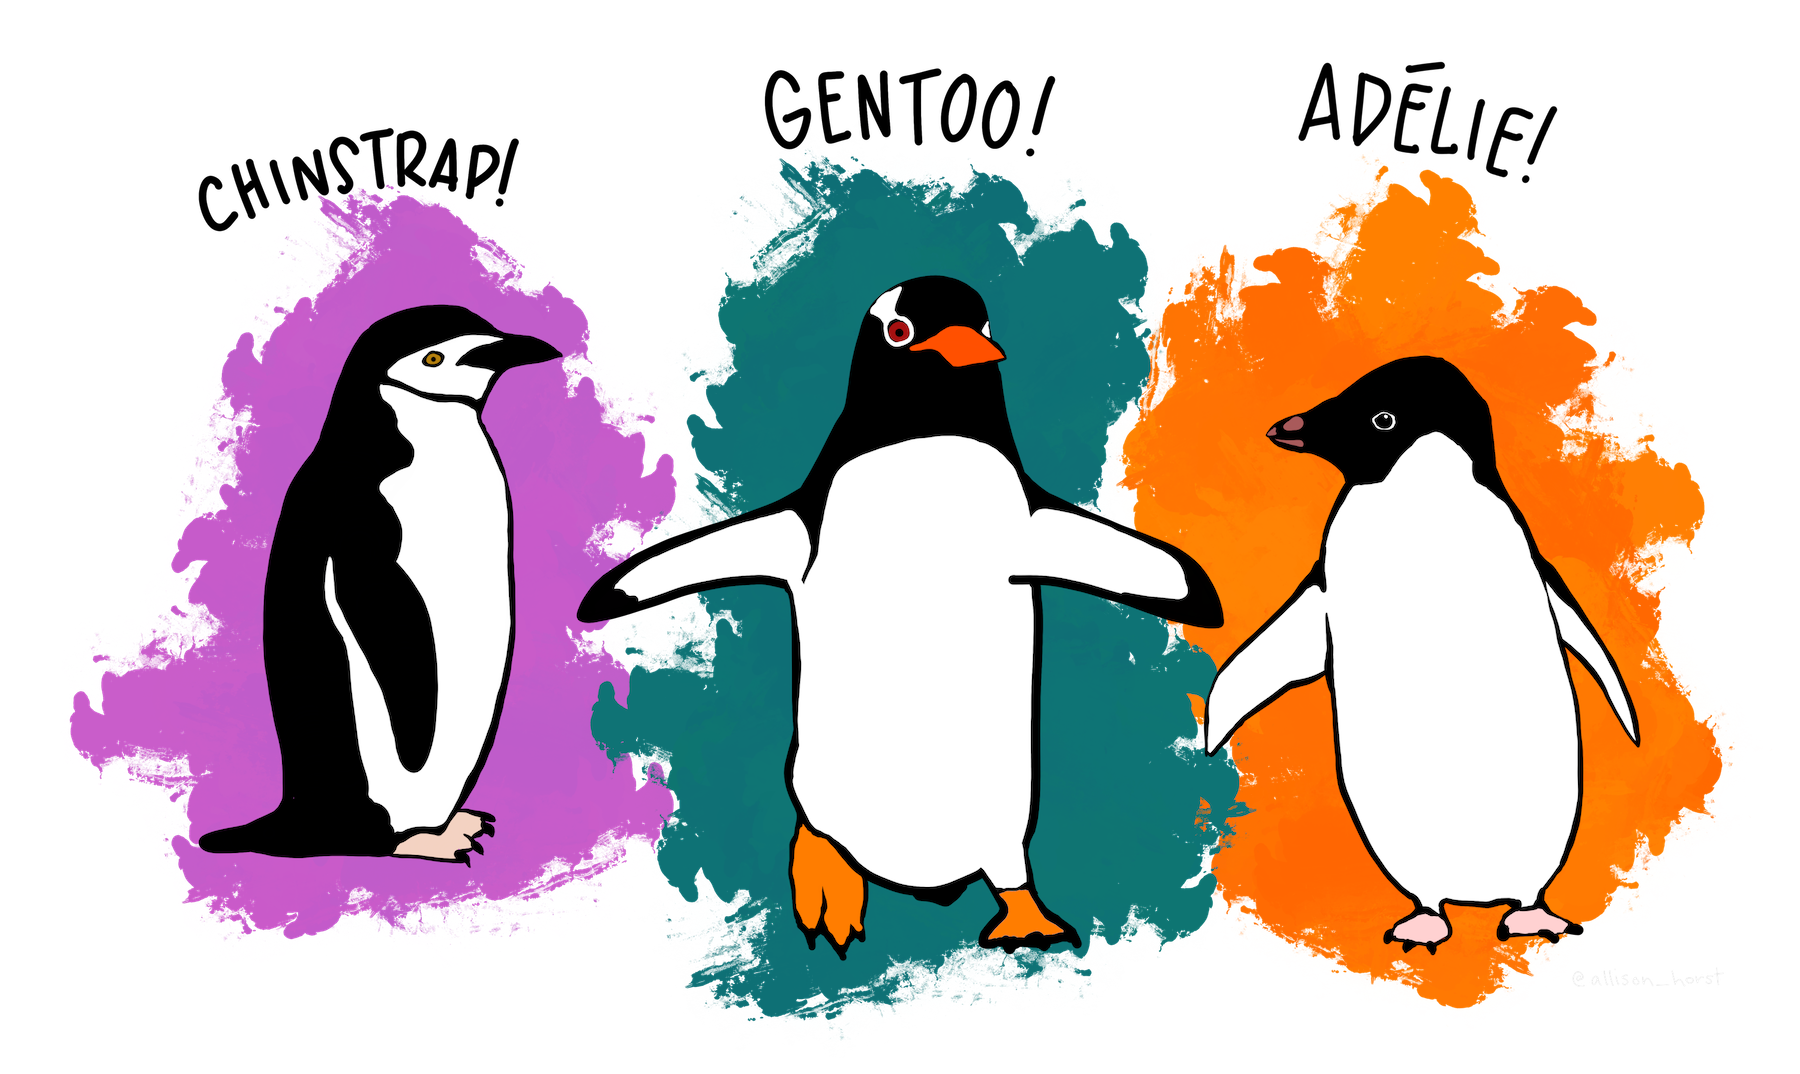

In [5]:
Image(os.path.join(image_path, "lter_penguins.png"))

In [6]:
display(penguins.head())
display(penguins.info())

species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
3  Adelie  Torgersen             NaN            NaN                NaN   
4  Adelie  Torgersen            36.7           19.3              193.0   

   body_mass_g     sex  
0       3750.0    Male  
1       3800.0  Female  
2       3250.0  Female  
3          NaN     NaN  
4       3450.0  Female

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


None

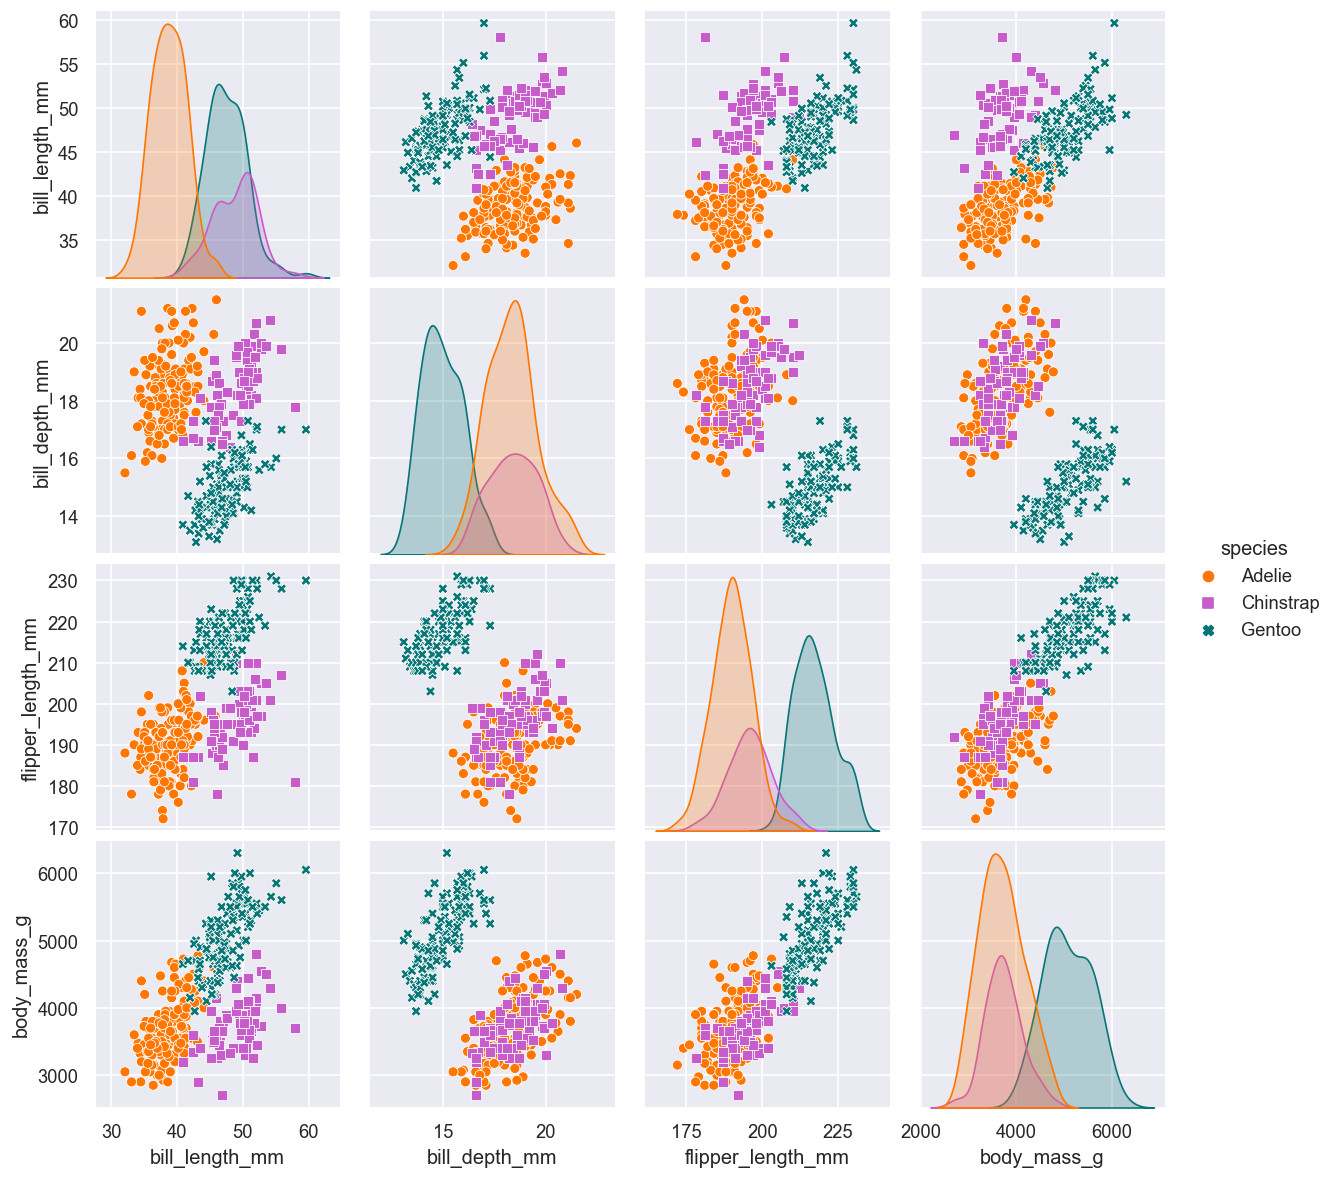

In [7]:
sns.pairplot(penguins, hue="species", markers=shape_dict, palette=col_dict)
plt.show()

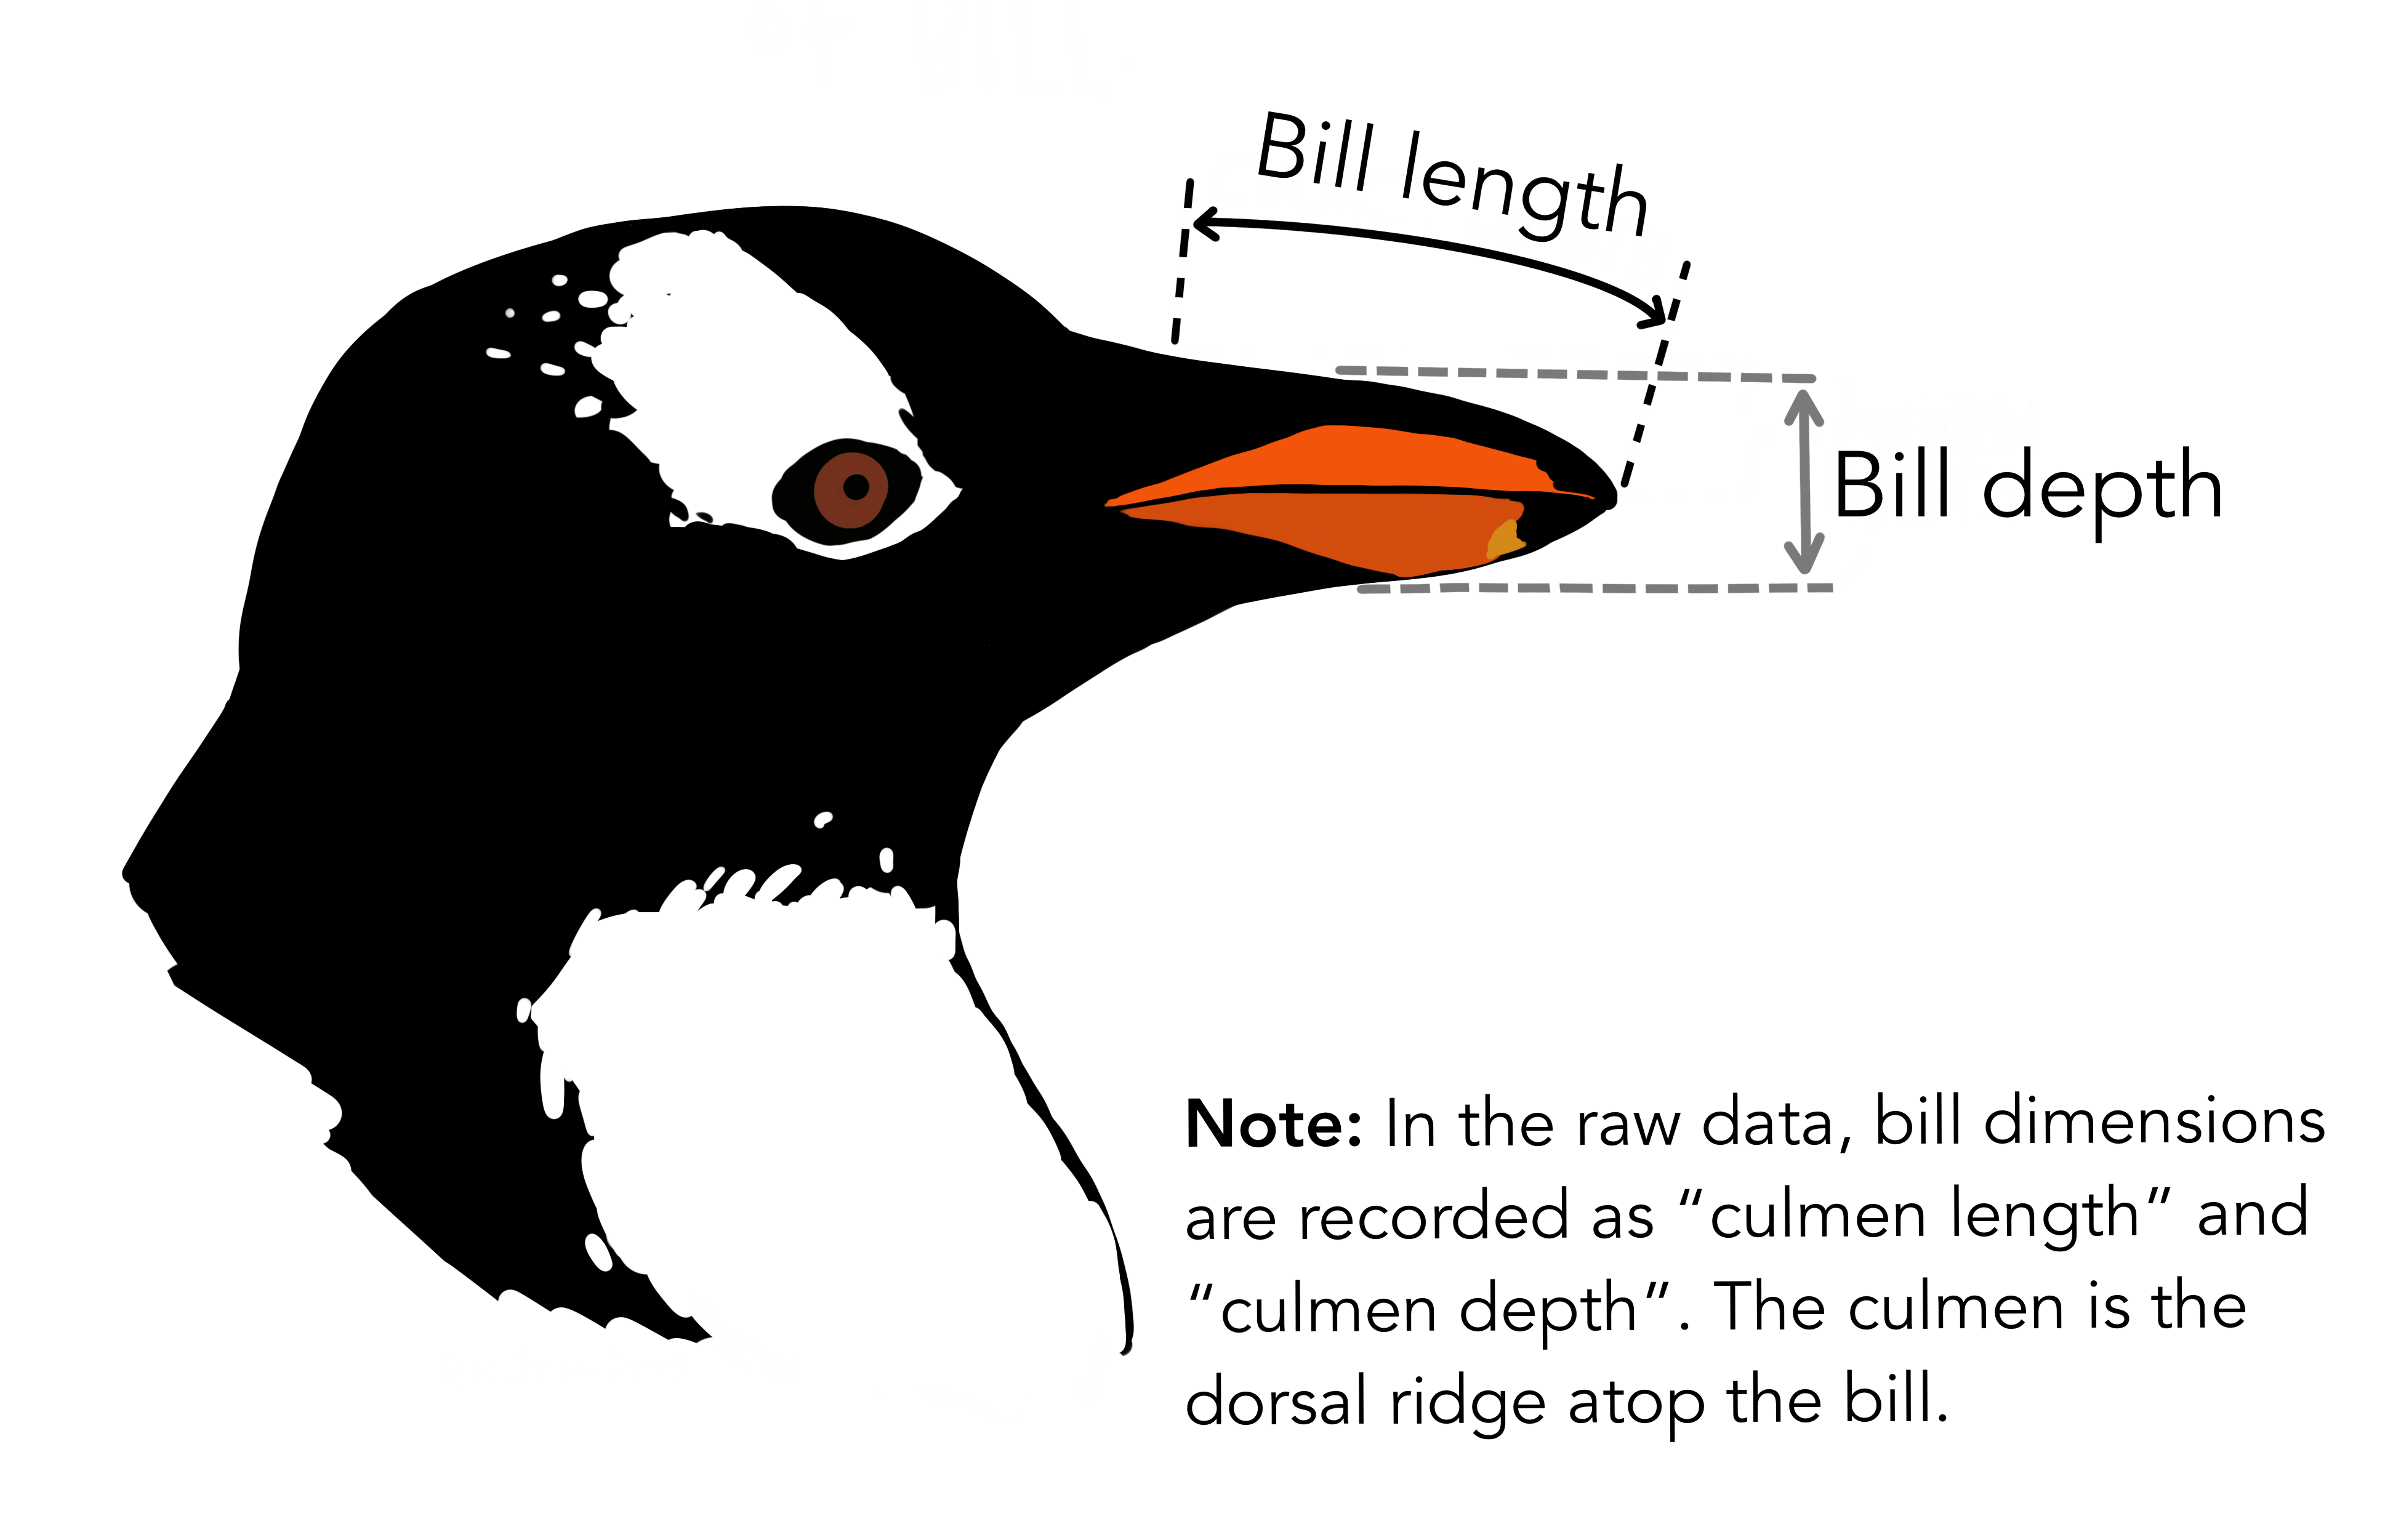

In [8]:
Image(os.path.join(image_path, "culmen_depth.png"))

# Regression Trees (A Quick Recap)
Lets try predict the body mass of a penguin based on their flipper length.

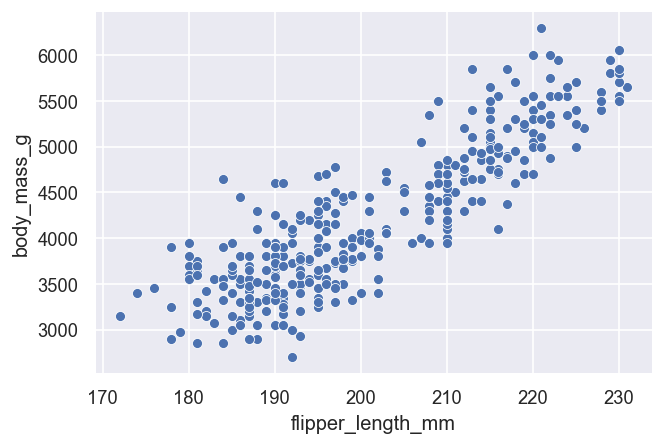

In [9]:
# drop categorical features as we wont use them much
penguins_cont = penguins.drop(["island", "sex"], axis=1).dropna()
flbm = penguins_cont[["flipper_length_mm", "body_mass_g"]]
g = sns.scatterplot(data=flbm, x = "flipper_length_mm", y = "body_mass_g")
#plt.title("")
plt.show()

As can be seen in the plot below, we split our data up into segments based on the depth of the tree (in the plot below using vertical lines), and given a new data point, we give it an estimated value by averaging the data in that segement (the horizontal line).

In [10]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

def plot_regression_predictions(tree_reg, X, y, axes=[170, 235, 2500, 6200], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r-", linewidth=2, label=r"$\hat{y}$")

def reg_plots(X, y, max_depths):

    fig, axes = plt.subplots(ncols=len(max_depths), nrows=2, figsize=(10, 8), sharey=True)

    thresh_dict = dict()
    lin_style_dict = dict()
    alpha=1
    lin_style = ['-', '--', ':']
    for i, depth in enumerate(max_depths):
        tree_reg = DecisionTreeRegressor(random_state=42, max_depth=depth)
        tree_reg.fit(X, y)
        plt.sca(axes[0, i])
        if i == 0:
            plot_regression_predictions(tree_reg, X, y)
        else:
            plot_regression_predictions(tree_reg, X, y, ylabel=None)
        for j in range(len(tree_reg.tree_.threshold)):
            if tree_reg.tree_.threshold[j] == -2:
                continue
            else:
                thresh = tree_reg.tree_.threshold[j]
                if thresh not in thresh_dict.keys():
                    thresh_dict[thresh]= alpha
                    lin_style_dict[thresh] = lin_style[i]
                plt.axvline(x=thresh, color='k', linestyle =lin_style_dict[thresh], alpha=thresh_dict[thresh])
        alpha-=0.2
        plt.legend(loc="upper left", fontsize=10)
        plt.title("max_depth="+str(depth), fontsize=14)

        tp = plot_tree(tree_reg,
                            feature_names=["flipper_length_mm"],
                            filled = True,
                            ax=axes[1, i]
                           )

    plt.show()

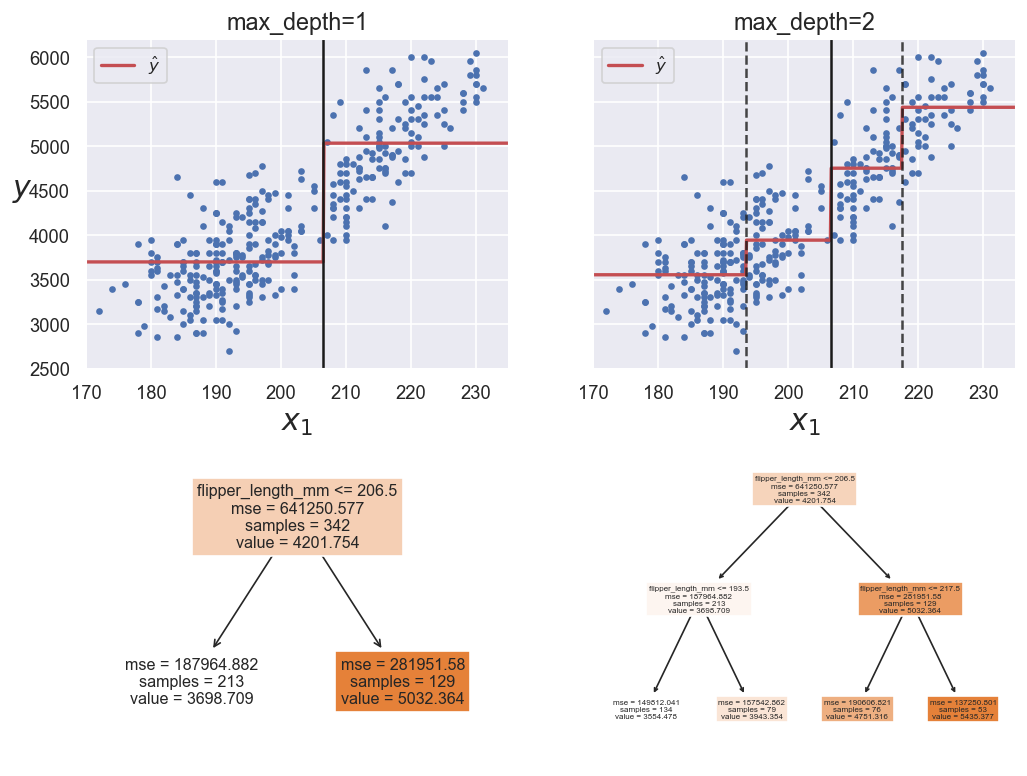

In [11]:
fl = flbm[["flipper_length_mm"]].values
bm = flbm[["body_mass_g"]].values.flatten()

reg_plots(fl, bm, max_depths = [1,2])

In more detail, there are two rough steps to a regression tree:
1. Divide the predictor space (the possible values for $X_1, X_2,...X_p$) into $J$ distinct non-overlapping regions, $R_1, R_2,...,R_j$.
2. For every obersravtion in region $R_j$, we make the same prediction, the mean responce for the training observations in $R_j$.

To construct these regions we divide the space into high-dimensional rectangles (boxes), with the goal to find the boxes $R_1, R_2,...,R_j$ that minimize the residual sum of squares (RSS):

$\sum^J_{j=1}\sum_{i\in R_j}(y_i - \hat y_{R_j})^2$,

where $\hat y_{R_j}$ is the mean responce for the training observations within the $j$th box.

---
James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. An introduction to statistical learning. Vol. 112. New York: springer, 2013.

We can't consider every possible partician of the feature space so we use recursive binary splitting (a top-down, greeedy approach). We begin at the top of the tree (all points in one region), and successively split the predictor space using the cutoff, $s$, that leads to the greatest reduction in RSS. In other words, we can define the half-planes as

$R_1(j,s) = \{X|X_j < s\}$ and $R_2(j,s) = \{X|X_j \geq s\}$,

and we seek the value of $j$ and $s$ to minimise

$\sum_{i: x_i\in R_1(j,s)}(y_i-\hat y_{R_1})^2 + \sum_{i: x_i\in R_2(j,s)}(y_i-\hat y_{R_2})^2$.

Provided $P$ is not too large, this can be done quite quickly. 

We then repeat the process, using the previously identified regions, until we reach a stopping criterion.

---
James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. An introduction to statistical learning. Vol. 112. New York: springer, 2013.

For another example, lets have more features (P) and see how we can visualise a shallow tree.

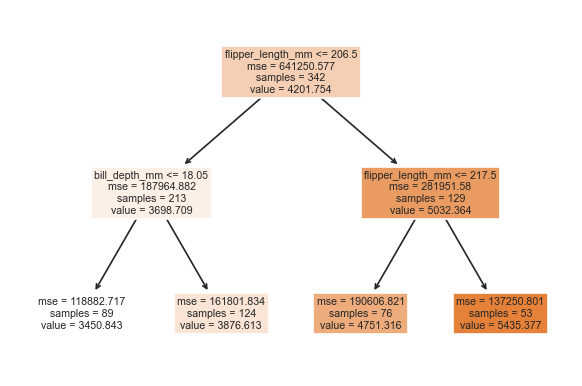

In [12]:
X_cont = penguins_cont.drop(["species", "body_mass_g"], axis=1).values
feats_cont = list(penguins_cont.drop(["species", "body_mass_g"], axis=1).columns)

tree_reg = DecisionTreeRegressor(random_state=42, max_depth=2).fit(X_cont,bm)
tp = plot_tree(tree_reg,
                   feature_names=feats_cont,
                   filled = True)

__Note__
- Sklearn uses MSE for the splitting criterion which is a standardised version of the RSS
- Rather than limiting the depth `max_depth` or setting a threshold `min_impurity_decrease` for the decrease in impurity, a good option is to use tree pruning `ccp_alpha`. For more on this read from pg. 307 in _An introduction to statistical learning_.

## Extra

Heres an additional visualisation, where we can follow the path of a hypetetical test sample. I don't use `dtreeviz` in the lectures, as it can be a bit of a hassle to setup. However you may also find this a useful way of thinking about the splitting.

**Notes**
- _"[INSERT QUOTE ABOUT REGRESSION DECISION]"_ https://explained.ai/decision-tree-viz/index.html

In [13]:
from re import search

# Change to True if you want to run the dtreeviz code
DTREEVIS = True

if DTREEVIS:
    if not search("graphviz", os.environ.get('PATH')):
        # CHANGE THIS TO WHERE graphviz IS ON YOUR COMPUTER!
        GRAPHVIS_PATH = 'C:/Users/delliot2/Anaconda3/envs/Teaching/Library/bin/graphviz/'
        os.environ["PATH"] += os.pathsep + GRAPHVIS_PATH

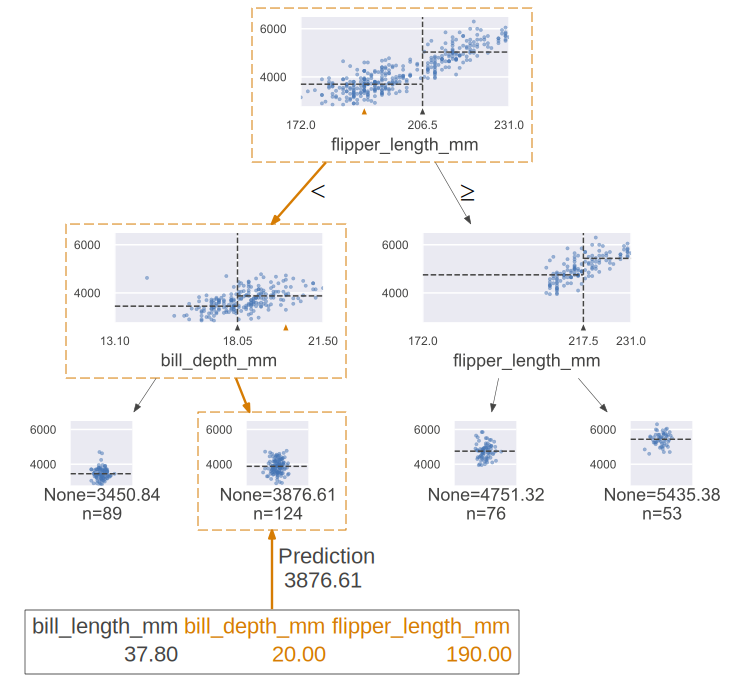

In [14]:
from dtreeviz.trees import dtreeviz
from sklearn.tree import DecisionTreeRegressor

if DTREEVIS:
    np.random.seed(seed=42)

    # random sample from training
    x_ = X_cont[np.random.randint(0, len(X_cont)),:] 

    viz = dtreeviz(tree_reg, X_cont, bm,
                   feature_names=feats_cont, scale=2.0, X=x_)
    display(viz)

# Decision Trees

A decision tree breaks data down by asking a series of questions in order to categorise samples into the same class. 

Scikit-Learn uses the Classification And Regression Tree (CART) algorithm to produce binary trees, meaning _nodes_ always have two children.

__Terminology__<sup>James</sup>
- The regions $R_1$ and $R_2$ are known as _terminal nodes_ or _leaves_ of the tree.
- The points where the predictor space is split are known as the _internal nodes_.
- The segments of the trees that connect the nodes are _branches_.

**Notes**
- Other algorithms, such as ID3, can have more children. 
- Leaves are typically drawn upside down, so they are at the bottom of the tree
- _"scikit-learn uses an optimised version of the CART algorithm; however, scikit-learn implementation does not support categorical variables for now."_ https://scikit-learn.org/stable/modules/tree.html
- The arrows dont show up on older versions of Scikit Learn due to a weird interaction with sns so I need to use `plt.style.context("classic")`. This has been fixed in later versions past what is currently availble on anaconda

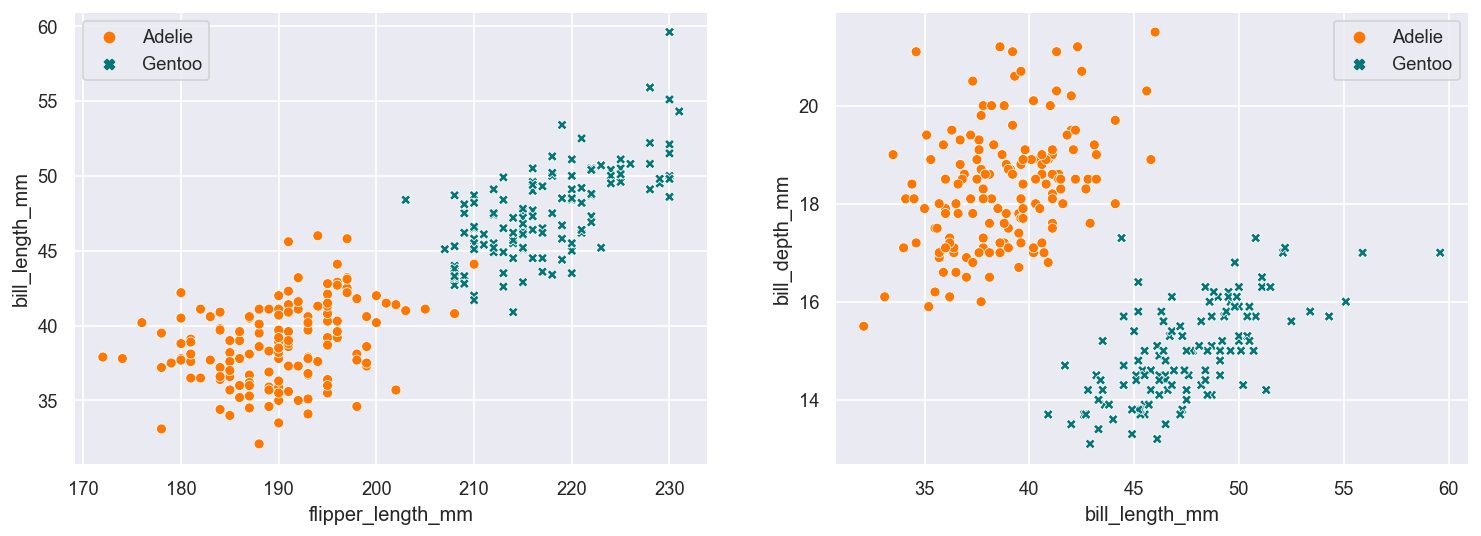

In [15]:
# TODO - REDUCE THIS RIGHT DOWN!

penguins_bin = penguins_cont[penguins_cont.species != "Chinstrap"]
y = penguins_bin[["species"]].replace({'Adelie': 0, 'Gentoo': 1}).values.flatten()

flbl = penguins_bin[["flipper_length_mm", "bill_length_mm", "species"]]
Xflbl = flbl[["flipper_length_mm", "bill_length_mm"]].values

blbd = penguins_bin[["bill_length_mm", "bill_depth_mm", "species"]]
Xblbd = blbd[["bill_length_mm", "bill_depth_mm"]].values

def bill_flipper_plots():
    fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
    plt.sca(axes[0])
    g = sns.scatterplot(data=flbl, x = "flipper_length_mm", 
                y = "bill_length_mm", hue="species", 
                style = "species", markers = shape_dict,  palette= col_dict)
    #plt.title("")
    g.axes.get_legend().set_title(False)
    
    
    plt.sca(axes[1])
    g = sns.scatterplot(data=blbd, x = "bill_length_mm", 
                y = "bill_depth_mm", hue="species", 
                style = "species", markers = shape_dict, palette = col_dict)
    #plt.title("")
    g.axes.get_legend().set_title(False)
    plt.show()
    
bill_flipper_plots()

In [16]:
from sklearn.tree import DecisionTreeClassifier
from mlxtend.plotting import plot_decision_regions
from sklearn import tree

DT = DecisionTreeClassifier(criterion='gini',
                            max_depth = 1,
                            random_state=42)

l_labels = [[189, 57.5],[219, 57.5]]
r_labels = [[0.225, 0.4],[0.725, 0.4]]
tp_labels = [[0.28, 0.5],[0.64, 0.5]]

def regions_tree(X, DT, feature_names, class_names, l_label_pos=None, r_label_pos=None, tp_label_pos=None, impurity = False):
    DT.fit(X,y)

    fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
    plt.sca(axes[0])

    scatter_kwargs = {"c":col_dict, "marker":shape_dict}
    ax = plot_decision_regions(X, y, clf = DT,
                               markers = [shape_dict["Adelie"], shape_dict["Gentoo"]],
                               colors = col_dict["Adelie"]+","+col_dict["Gentoo"]
                              )

    handles, labels = ax.get_legend_handles_labels()
    
    if l_label_pos:
        plt.text(l_label_pos[0][0], l_label_pos[0][1], "$R_1$", bbox=dict(facecolor='white', alpha=0.3))
        plt.text(l_label_pos[1][0], l_label_pos[1][1], "$R_2$", bbox=dict(facecolor='white', alpha=0.3))
    
    ax.legend(handles, 
              class_names, 
              framealpha=0.3, scatterpoints=1)

    plt.xlabel(feature_names[0]) 
    plt.ylabel(feature_names[1])
    with plt.style.context("classic"):
        plt.sca(axes[1])
        tp = tree.plot_tree(DT,
                       feature_names=feature_names, 
                       class_names=class_names,
                       filled = True,
                           impurity = impurity)
        if r_label_pos:
            axes[1].text(r_label_pos[0][0], r_label_pos[0][1],
                         "$R_1$")
            axes[1].text(r_label_pos[1][0], r_label_pos[1][1], 
                         "$R_2$")
            
        if tp_label_pos:
            axes[1].text(tp_label_pos[0][0], tp_label_pos[0][1],
                         "False", {'fontweight':'bold'})
            axes[1].text(tp_label_pos[1][0], tp_label_pos[1][1], 
                         "True", {'fontweight':'bold'})
        
        tp[1].set_backgroundcolor(col_dict["Adelie"])
        tp[2].set_backgroundcolor(col_dict["Gentoo"])

    plt.show()

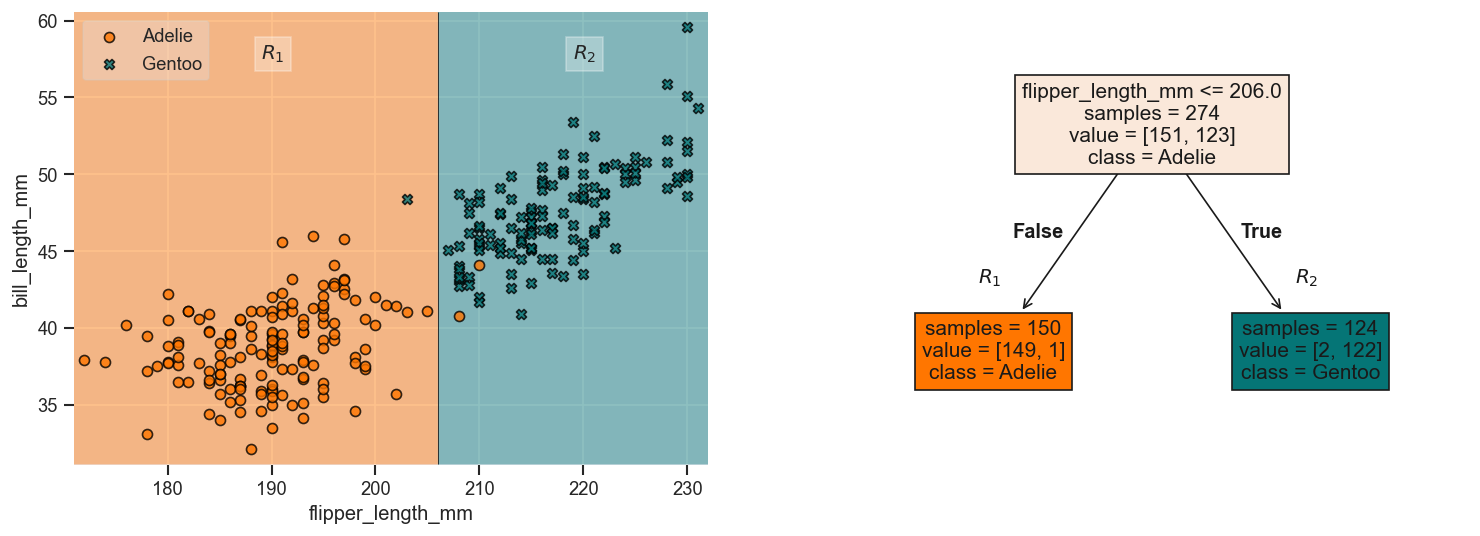

In [17]:
regions_tree(Xflbl, DT, flbl.columns[:-1], ['Adelie', 'Gentoo'], l_labels, r_labels, tp_labels)

Heres an additional visualisation I don't go through in the lectures, however you may also find this a useful way of thinking about the splitting.  It is however more of a hassle to get it set-up (due to "graphviz" needing to be on the "PATH"), so you may have problems getting it to work (consider it additional).

**Notes**

- _"For classifiers, however, the target is a category, rather than a number, so we chose to illustrate feature-target space using histograms as an indicator of feature space distributions."_ https://explained.ai/decision-tree-viz/index.html

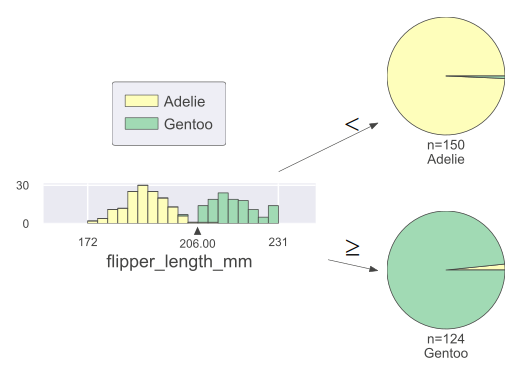

In [18]:
if DTREEVIS:
    DT.fit(Xflbl, y)

    viz = dtreeviz(DT, Xflbl, y,
                   feature_names=flbl.columns[:-1],
                   class_names=['Adelie', 'Gentoo'],
                   orientation ='LR', colors = col_dict, scale=2.0
                  )
    display(viz)

## Information Gain

An algorithm starts at a tree root and then splits the data based on the features that gives the largest _information gain_. This splitting procedure occours until all the samples within a given node all belong to the same class<sup>Raschka</sup>, the maximum depth of the tree is reached, or a split cannot be found that reduces impurity<sup>Géron</sup>. 

To split using information gain relies on calculating the difference between an impurity measure of a parent node and the sum of the impurities of its child nodes; information gain being high when impurity of the child nodes is low. 

Three impurity measures that are commonly used in binary decision trees are the _classification error_, _gini impurity_, and _entropy_<sup>1</sup>. 

---
1. Raschka, Sebastian, and Vahid Mirjalili. Python Machine Learning, 2nd Ed. Packt Publishing, 2017.

### Classification Error

This is simply the fraction of the training observations in a region that does not belong to the most common class:

$E = 1 - \substack{max\\k}(\hat p_{mk})$.

$\hat p_{mk}$ here is the proportion of training observations in the $m$th region that are from the $k$th class.

---
James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. An introduction to statistical learning. Vol. 112. New York: springer, 2013.

__Notes__
- However this is rarely used in practice because geni index or entropy are better.. its not even an option in scikit-learn

### Gini Impurity
Measures the total variance across $K$ classes,

$G = \sum^K_{k=1}\hat p_{mk}(1-\hat p_{mk})$.

It is a measure of node _"purity"_ as a small value indicates a node contains predominantly overvations from a single class.

---
James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. An introduction to statistical learning. Vol. 112. New York: springer, 2013.

__Notes__

- It takes a small value if all of the $\hat p_{mk}$'s are close to 0 or 1

In [19]:
DT = DecisionTreeClassifier(criterion='gini',
                            max_depth = 1,
                            random_state=42)

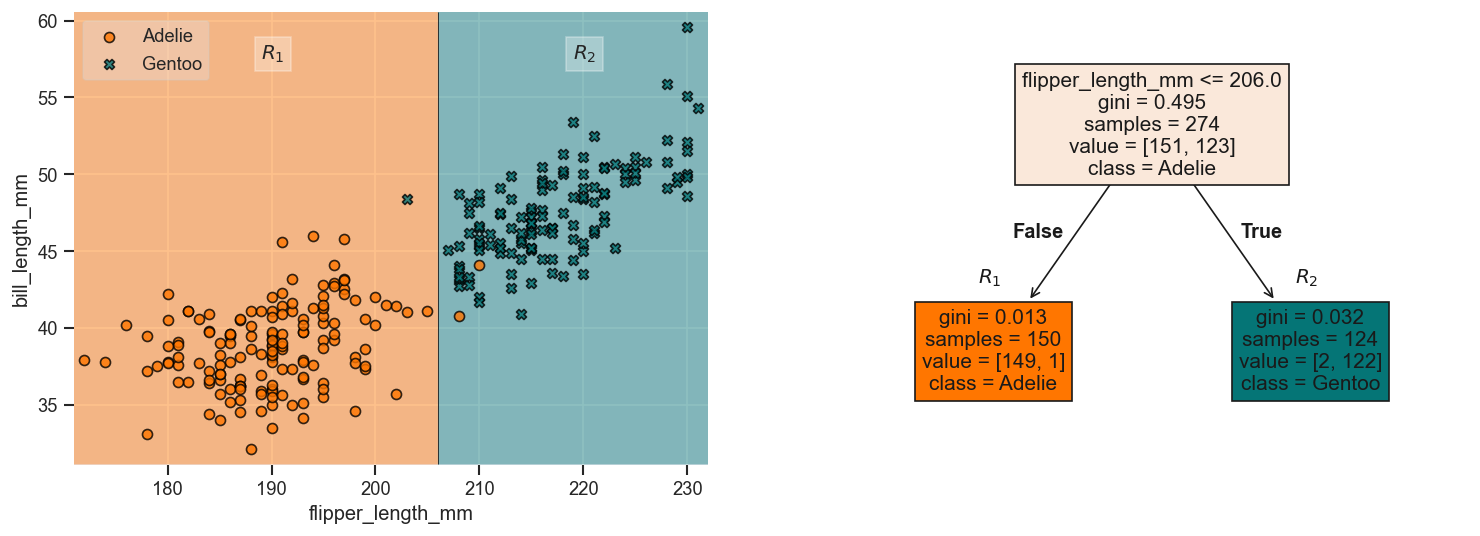

In [20]:
regions_tree(Xflbl, DT, flbl.columns[:-1], ['Adelie', 'Gentoo'], l_labels, r_labels, tp_labels, impurity = True)

### Entropy Impurity
Entropy is an alternative measurement, given by

$D = -\sum^K_{k=1}\hat p_{mk}log \hat p_{mk}$.

Entropy will take on a value near 0 if the $\hat p_{mk}$'s are all near 0 or 1, therefore will take on a small value if the $m$th node is pure.

In [21]:
DT = DecisionTreeClassifier(criterion='entropy',
                            max_depth = 1,
                            random_state=42)

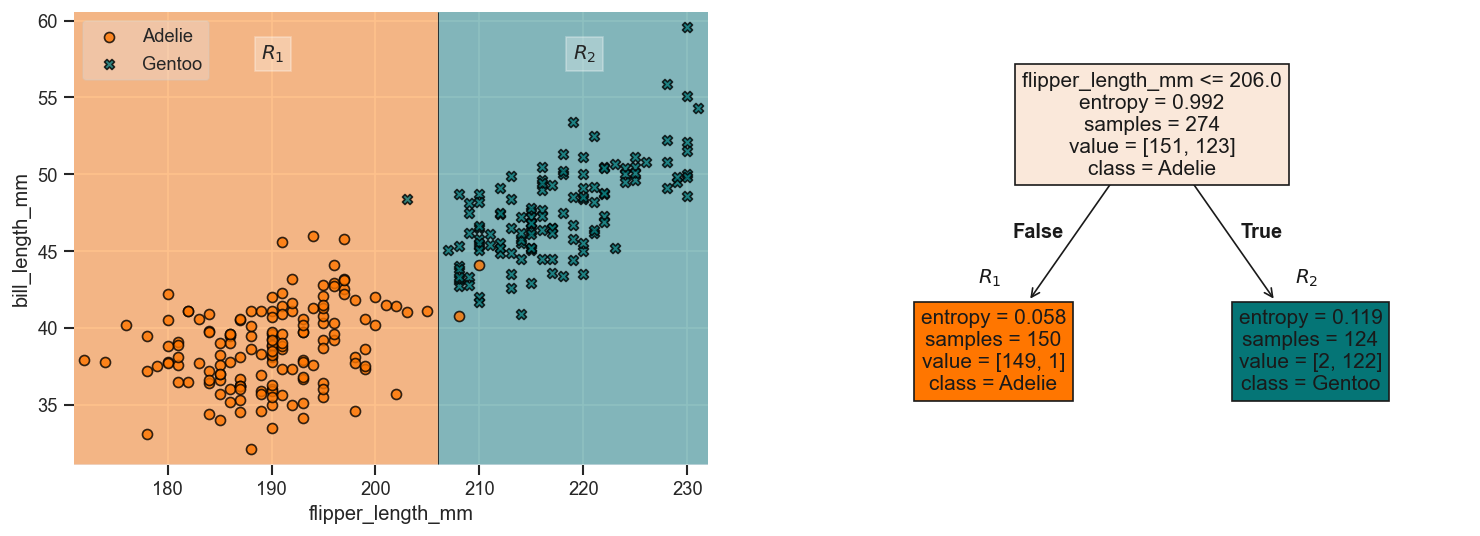

In [22]:
regions_tree(Xflbl, DT, flbl.columns[:-1], ['Adelie', 'Gentoo'], l_labels, r_labels, tp_labels, impurity = True)

## Pruning

__[Insert about pruning]__

## Categorical Varibles

Do not use `Label Encoding` if your categorical data is __not ordinal__ with `DecisionTreeClassifier()`, you'll end up with splits that do not make sense, as the data will be treat as numeric<sup>Web</sup>.

Using a `OneHotEncoder` is the only current valid way, allowing arbitrary splits not dependent on the label ordering, but is computationally expensive. However this can deteriorate the performance of decision trees as it leads to sparse features, which can mess up feature importance<sup>Web</sup>.

__TODO__
- then what do we do?

---
Web. https://stackoverflow.com/questions/38108832/passing-categorical-data-to-sklearn-decision-tree

**Notes**
- _"scikit-learn uses an optimised version of the CART algorithm; however, scikit-learn implementation does not support categorical variables for now."_ https://scikit-learn.org/stable/modules/tree.html

## Advantages
- Trees are very easy to explain

- Decision trees potentially more mirror human decision-making than the regression and classification approaches previously discussed.

- Trees can be displayed graphically, and are easily interpreted.

- Trees can easily handle qualitative predictors without the need to create dummy variables.

---
James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. An introduction to statistical learning. Vol. 112. New York: springer, 2013.

### Assessing Feature Importance

Decision trees allow us assess the importance of each feature for classifying the data. The importance (or Gini importance) of a feature is the normalized total reduction of the criterion (e.g. Gini) brought by that feature.

---
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

__Notes__
- Lets fit all the penguins on the full data (without categories) and see what features are used to split the data and where they are in the tree. 
- For bagging regression trees we can use the RSS.

In [52]:
X = penguins_bin.drop("species",axis=1).values
y = penguins_bin[["species"]].replace({'Adelie': 0, 'Gentoo': 1}).values.flatten()

DT = DecisionTreeClassifier(criterion='gini',
                            max_depth = None,
                            random_state=42)

DT.fit(X, y)

feat_names = penguins_bin.drop("species",axis=1).columns

def tree_feat_import(DT, X, y, feat_names, title):

    # get the importances for the features
    importances = DT.feature_importances_

    importances_series = pd.Series(importances,index=feat_names).sort_values(ascending = False)

    # plot the important features
    importances_series.plot.bar(legend =False, grid=False)
    plt.title(title)

    plt.xticks(rotation=45,ha='right')
    plt.tight_layout()

    #plt.savefig('forest_importances.png', dpi=300)
    plt.show()

    # summarize feature importance
    for i,v in enumerate(importances):
        print(color.BOLD+feat_names[i]+color.END+": %.3f" % (v))

    print(color.BOLD+"total: "+color.END + str(round(sum(importances),2)))

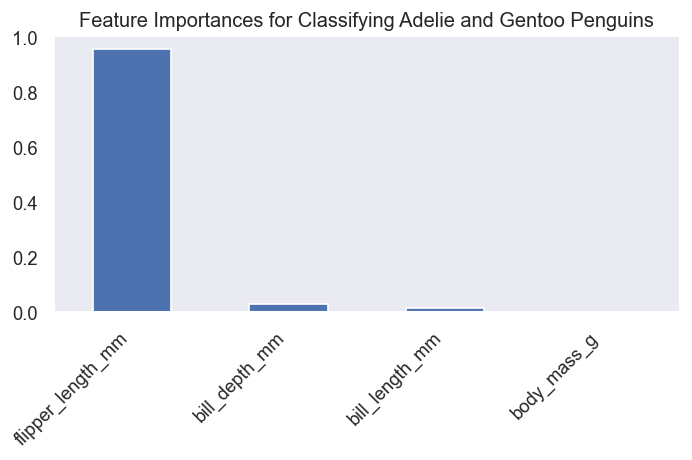

bill_length_mm: 0.015
bill_depth_mm: 0.029
flipper_length_mm: 0.956
body_mass_g: 0.000
total: 1.0


In [53]:
tree_feat_import(DT, X, y, feat_names,
                 'Feature Importances for Classifying Adelie and Gentoo Penguins')

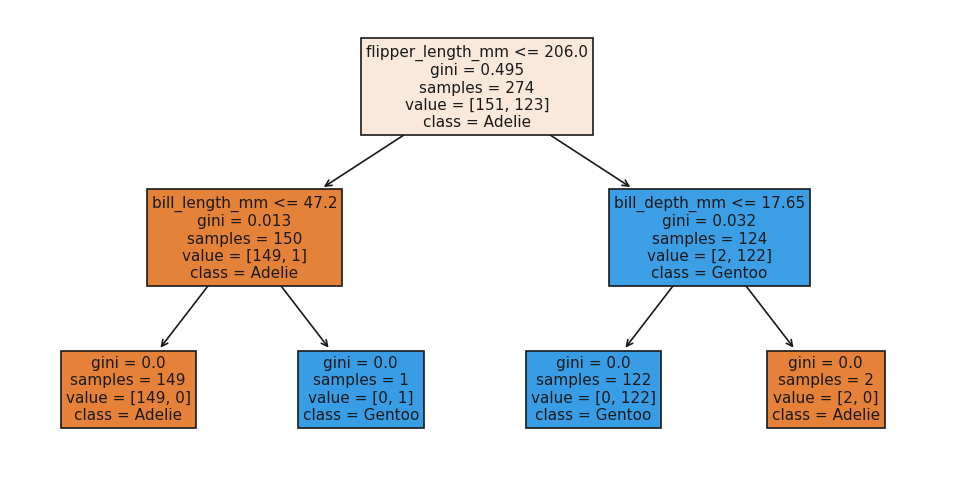

In [54]:
fig, axes = plt.subplots(figsize=(10,5))
with plt.style.context("classic"):
    tree.plot_tree(DT,
                   feature_names=penguins_bin.drop("species",axis=1).columns, 
                   class_names=['Adelie', 'Gentoo'],
                   filled = True)
    plt.show()

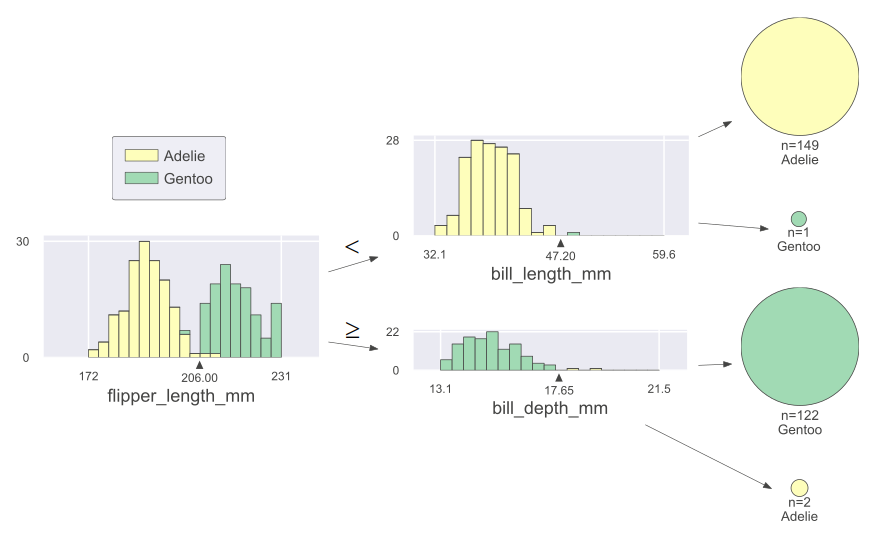

In [55]:
if DTREEVIS:
    viz = dtreeviz(DT, X, y,
                   feature_names=penguins_bin.columns[1:],
                   class_names=['Adelie', 'Gentoo'],
                   orientation ='LR', 
                   colors = col_dict, # doesnt seem to do much..
                   scale=2.0
                  )
    display(viz)

### Multiclass
Tree-based classifiers are inherently multiclass...

__[Insert about multiclass]__

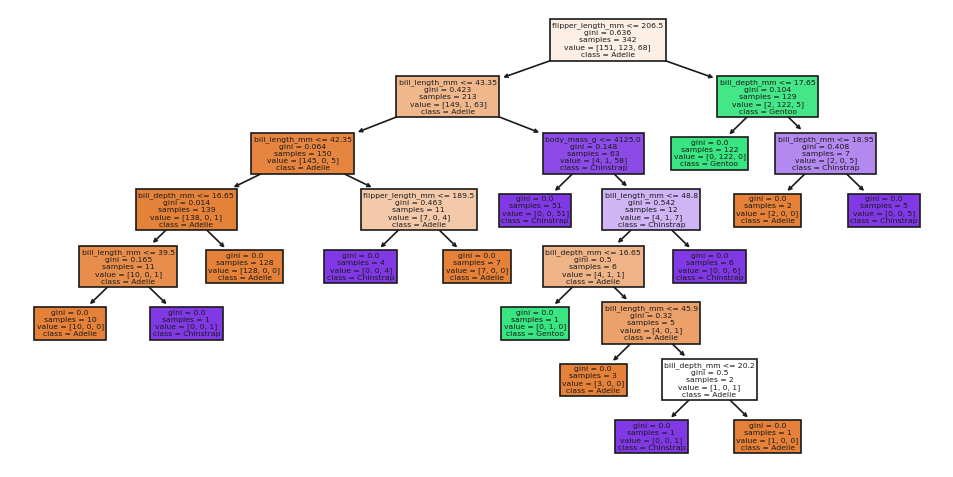

['Adelie', 'Gentoo', 'Chinstrap']


In [56]:
X = penguins_cont.drop("species",axis=1).values
y = penguins_cont[["species"]].replace({'Adelie': 0, 'Gentoo': 1, "Chinstrap":2}).values.flatten()

DT = DecisionTreeClassifier(criterion='gini',
                            max_depth = None,
                            random_state=42)

DT.fit(X, y)

feat_names = penguins_cont.drop("species",axis=1).columns

fig, axes = plt.subplots(figsize=(10,5))
with plt.style.context("classic"):
    tree.plot_tree(DT,
                   feature_names=feat_names, 
                   class_names=['Adelie', 'Gentoo', 'Chinstrap'],
                   filled = True)
    plt.show()
print("['Adelie', 'Gentoo', 'Chinstrap']")

__Extra__

Unsurprisingly, more features are needed to separate out the multi-class problem than in the binary class as can be seen below

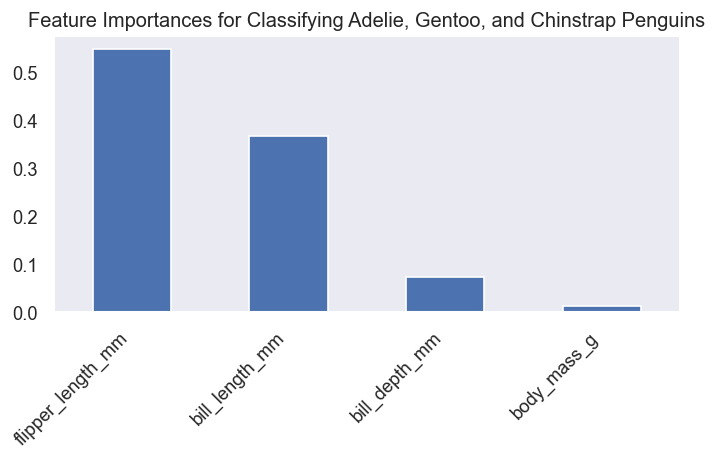

bill_length_mm: 0.366
bill_depth_mm: 0.073
flipper_length_mm: 0.548
body_mass_g: 0.013
total: 1.0


In [57]:
tree_feat_import(DT, X, y, feat_names, 'Feature Importances for Classifying Adelie, Gentoo, and Chinstrap Penguins')

## Disadvantages

- Trees generally do not have the same level of predictive accuracy as some of the other regression and classification approaches.

- A small change in the data can cause a large change in the final estimated tree.

However, by aggregating many decision trees, using methods like bagging, random forests, and boosting, the predictive performance of trees can be substantially improved. We introduce these concepts in the next section.

---
James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. An introduction to statistical learning. Vol. 112. New York: springer, 2013.

### Rotation of the Data
As can be seen by the descision boundary, a decision tree is quite boxy. Furthermore, how the model makes a decision boundary is going to be affected by the rotation of the data (as DTs create straight lines).

In [25]:
DT2 = DecisionTreeClassifier(criterion='gini',
                            max_depth = None,
                            random_state=42)

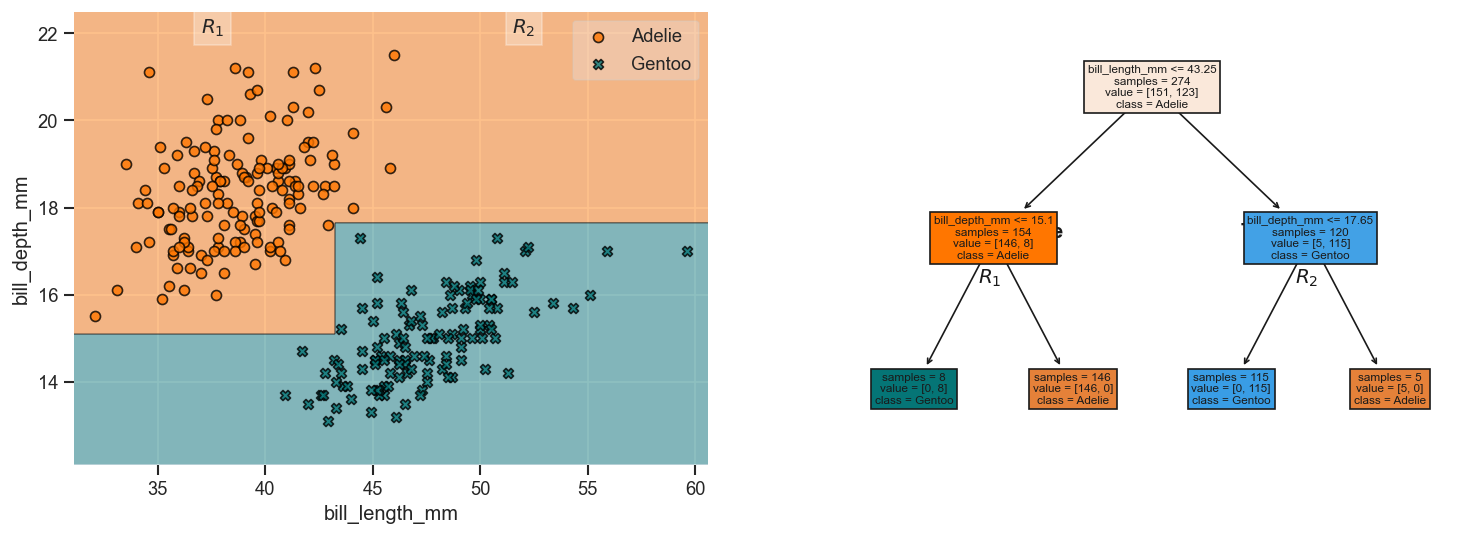

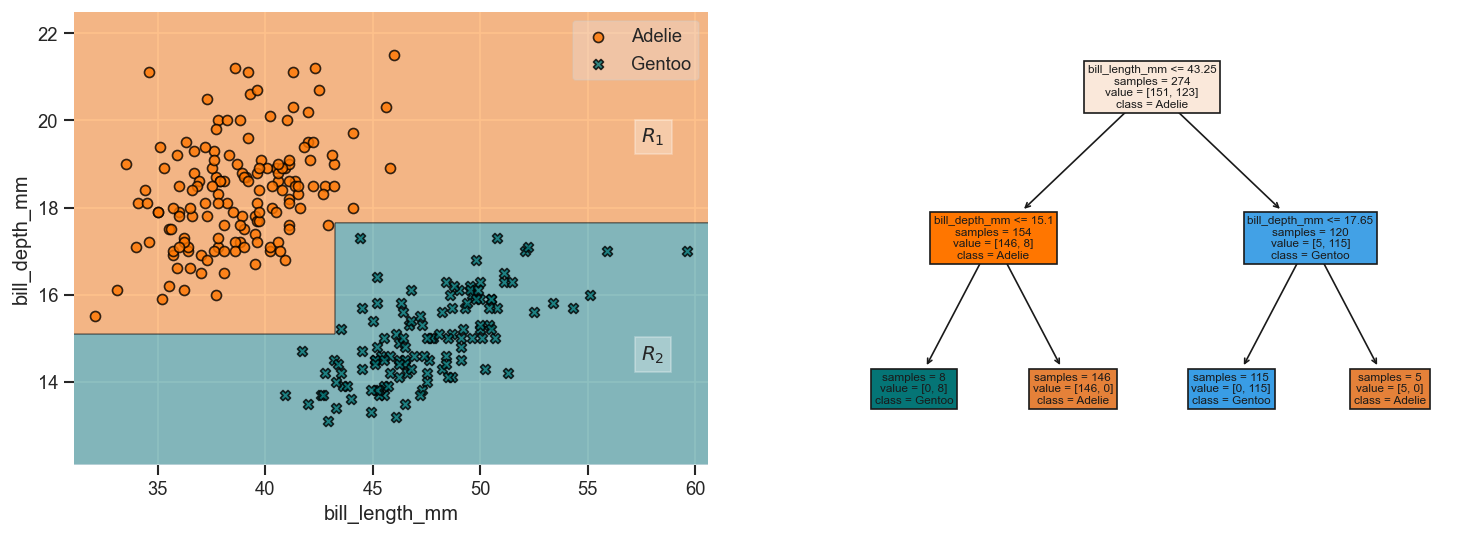

In [26]:
regions_tree(Xblbd, DT, blbd.columns[:-1], ['Adelie', 'Gentoo'],  [[37, 22],[51.5, 22]], r_labels, tp_labels)
regions_tree(Xblbd, DT2, blbd.columns[:-1], ['Adelie', 'Gentoo'], [[57.5, 19.5],[57.5, 14.5]])

#### "Classical Approachs" or Trees?

Which approach may be better really depends on the relationship between the features and the responce.

If there is a highly non-linear and complex relationship between the features and the response then decision trees may outperform classical approaches. However if the relationship between the features and the response is well approximated by a linear model, then an approach such as linear regression will likely work well, and will outperform a method such as a regression tree that does not exploit this linear structure. 

The relative performances of tree-based and classical approaches can be assessed by estimating the test error, using either cross-validation or the validation set approach.

---
James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. An introduction to statistical learning. Vol. 112. New York: springer, 2013.

__Notes__

- Linear regression assumes a model of the form $f(X)=\beta 0+\sum_{j=1}^p X_j\beta_j$,

- Regression trees assume a model of the form $f(X)=\sum_{m=1}^Mc_m\cdot1_{(X\in R_m)}$, where $R_1, …, R_M$ represent a partition of feature space. 

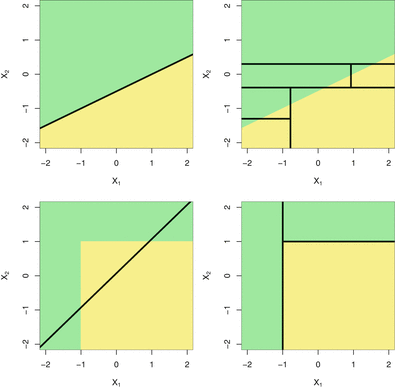

In [27]:
Image(os.path.join("fig_8-7.png"))

### Overfitting

A limit on nodes, or tree depth, is often set to avoid overfitting due to a deep tree<sup>2</sup>. 

---
2. Raschka, Sebastian, and Vahid Mirjalili. Python Machine Learning, 2nd Ed. Packt Publishing, 2017.

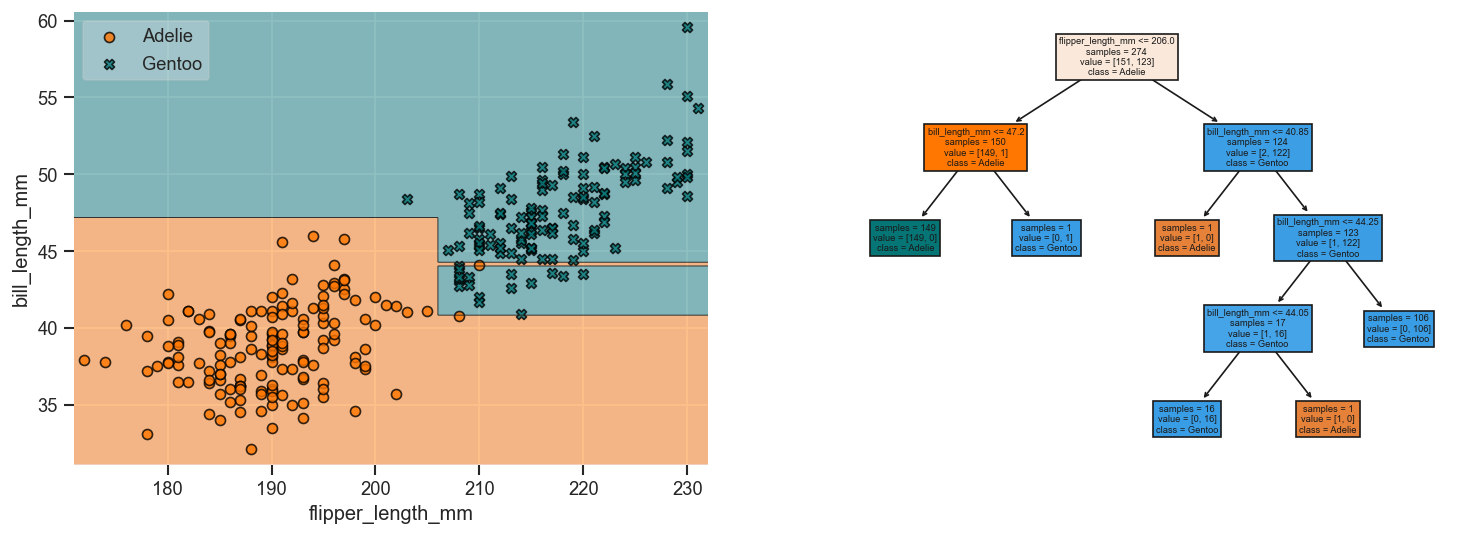

In [28]:
DT = DecisionTreeClassifier(criterion='gini',
                            max_depth = None,
                            random_state=42)
regions_tree(Xflbl, DT, flbl.columns[:-1], ['Adelie', 'Gentoo'])

## Exercises
[THEORY BASED!]

1.

2.

# Averaging Methods
Averaging methods build several separate estimators and then, as their name suggets, average their predictions. 

By reducing the variance these tend to perform better than any single base estimator<sup>1</sup>.

Averaging methods generally work best when the predictors are as independent as possible, so one way of achiving this is to get diverse classifiers. This increases the chance they each make different types of errors which in combination will improve the overall accuracy<sup>3</sup>.

---
1. Raschka, Sebastian, and Vahid Mirjalili. Python Machine Learning, 2nd Ed. Packt Publishing, 2017.
3. Géron, A. (2017). Hands-on machine learning with Scikit-Learn and TensorFlow: concepts, tools, and techniques to build intelligent systems. " O'Reilly Media, Inc.".

__NOTES__
- __High Variance__ means if we split the training data into two parts at random, and fit a decision tree to both halves, the results that we get could be quite different. 
- __Low Variance__ means a procedure will yield similar results if applied repeatedly to distinct data sets.
- Decision trees typically suffer from _high variance_.
- Linear regression tends to have low variance, if the ratio of n to p is moderately large.

For example an ensemble of decision trees can be created to build a more robust model by giving each tree a random bootstrap sample of the data and using a majority voting rule to predict class label<sup>1</sup>. 

---
1. Raschka, Sebastian, and Vahid Mirjalili. Python Machine Learning, 2nd Ed. Packt Publishing, 2017.

## Bootstrap (A Quick Recap)

__TODO__
- chapter 5 of James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. An introduction to statistical learning. Vol. 112. New York: springer, 2013.

## Bagging
A bagging classifier is an ensemble of base classifiers, each fit on random subsets of a dataset. Their predictions are then pooled or aggregated to form a final prediction. This reduces _variance_ of an estimator so can be a simple way to reduce overfitting and increase prediction accuracy<sup>1</sup>. 

This is because the variance of the mean $\bar Z$ of $n$ independent observations, $Z_1,...,Z_n$, is given by $\sigma^2/n$; meaning averaging a set of observations reduces variance. Can can use this by taking many separate training sets, $B$, from the population, building a separate prediction model using each training set, $\hat f^1(x),\hat f^2(x),...,\hat f^B(x)$, and average the resulting predictions<sup>2</sup>:

$\hat f_{avg}(x)=\frac{1}{B}\sum_{b=1}^B\hat f^b(x)$.

However we generally do not have access to multiple training sets so instead we can bootstrap by taking repeated samples from a (single) training data set to create multiple bootstrapped training data sets, $B$. We then train our method on the $b$th bootstrapped training set to get $f^{∗b}(x)$ , and finally average all the predictions, to obtain<sup>2</sup>:

$\hat f_{bag}(x) = \frac{1}{B}\sum_{b=1}^B\hat f^{∗b}(x)$.

---
1. https://scikit-learn.org/stable/modules/ensemble.html

2. James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. An introduction to statistical learning. Vol. 112. New York: springer, 2013.

Specifically, bagging is when sampling is produced with replacement<sup>2</sup>, and without replacement being called _pasting_<sup>3</sup>. 

Pasting is designed to use smaller sample sizes than the training dataset in cases where the training dataset does not fit into memory<sup>3</sup>.

Both bagging and pasting allow training to be sampled several times across multipule predictors, with bagging only allowing several samples for the same predictor <sup>4</sup>.

---
2. Breiman, L. (1996). Bagging predictors. Machine learning, 24(2), 123-140.
3. Breiman, L. (1999). Pasting small votes for classification in large databases and on-line. Machine learning, 36(1-2), 85-103.
4. Géron, A. (2017). Hands-on machine learning with Scikit-Learn and TensorFlow: concepts, tools, and techniques to build intelligent systems. " O'Reilly Media, Inc.".

__NOTES__

- If we wanted to use pasting we would just set `bootstrap=False`.

In [71]:
from sklearn.ensemble import BaggingClassifier

X = penguins_cont.drop("species",axis=1).values
y = penguins_cont[["species"]].replace({'Adelie': 0, 'Gentoo': 1, "Chinstrap":2}).values.flatten()

bag = BaggingClassifier(base_estimator=DT, 
                        n_estimators=100, 
                        max_samples=0.8, 
                        max_features=1., 
                        bootstrap=True, 
                        bootstrap_features=False, 
                        oob_score=True, 
                        warm_start=False,
                        n_jobs=-1, 
                        random_state=42)
bag.fit(X, y)

BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  max_samples=0.8, n_estimators=100, n_jobs=-1, oob_score=True,
                  random_state=42)

In practice, _bagging_ tends to work best with complex models<sup>1</sup>, so although bagging is useful when applied to regression methods, they are particularly useful for decision trees <sup>2</sup>.

Bagging has been demonstrated to give impressive improvements in accuracy by combining together hundreds or even thousands of trees into a single procedure.

These trees are grown deep, and are not pruned so each individual tree has high variance, but low bias. Averaging these $B$ trees reduces the variance.

To apply bagging to __regression trees__, we simply:
1. construct $B$ regression trees using $B$ bootstrapped training sets, 
2. average the resulting predictions. 

To apply bagging to __decision trees__, we simply:
1. construct $B$ decision trees using $B$ bootstrapped training sets, 
2. take a majority vote of the resulting predictions.

---
1. https://scikit-learn.org/stable/modules/ensemble.html
2. James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. An introduction to statistical learning. Vol. 112. New York: springer, 2013.
3. Géron, A. (2017). Hands-on machine learning with Scikit-Learn and TensorFlow: concepts, tools, and techniques to build intelligent systems. " O'Reilly Media, Inc.".

__Notes__
- _boosting_ will generally work better with weak models.
- _[Explanation of bias]_
- Have a look at _Majority Voting_ from the last lecture.

### Out-of-Bag Error Estimation
Using a bagged model means we can get a validation/test error without using cross-validation.

On average, each bagged tree uses around two-thirds of the observations<sup>1, REF</sup>, therefore we can predict these out-of-bag (OOB) observations using only the trees that were not fit using those observations.

With a sufficiently amount of bags, OOB error is virtually equivalent to leave-one-out cross-validation error, which is convenient when performing bagging on large data sets for which cross-validation would be computationally onerous<sup>1</sup>.

---
1. James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. An introduction to statistical learning. Vol. 112. New York: springer, 2013.

__NOTES__

- we use `oob_score = True`

### Variable Importance Measures

Bagging improves prediction accuracy at the expense of interpretability.

However we can use the feature importance method as previously discussed, to get an overall summary of the importance of each predictor across trees.

__NOTES__
- Bagging can be used with most classifiers, although you can only assess feature importances if a method provides a `feature_importances_`.
- _"Recall that one of the advantages of decision trees is the attractive and easily interpreted diagram that results... However, when we bag a large number of trees, it is no longer possible to represent the resulting statistical learning procedure using a single tree, and it is no longer clear which variables are most important to the procedure."_<sup>1</sup>

---
1. James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. An introduction to statistical learning. Vol. 112. New York: springer, 2013.

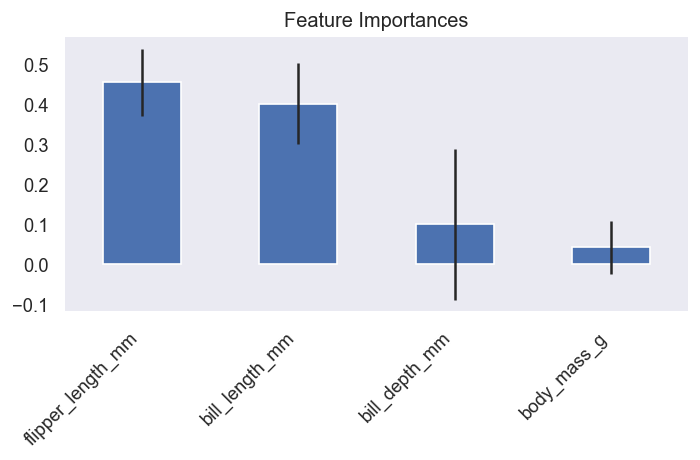

In [74]:
# get the importances for the features
importances = np.mean([
    tree.feature_importances_ for tree in bag.estimators_
], axis=0)

importances_sd = np.std([
    tree.feature_importances_ for tree in bag.estimators_
], axis=0)

feat_names = penguins_cont.drop("species",axis=1).columns
importances_series = pd.Series(importances,index=feat_names).sort_values(ascending = False)

# plot the important features
importances_series.plot.bar(legend =False, grid=False, yerr=importances_sd)
plt.title('Feature Importances')

plt.xticks(rotation=45,ha='right')
plt.tight_layout()

#plt.savefig('forest_importances.png', dpi=300)
plt.show()

## Random Forests

Random forests are essentally bagged tree classifiers, but decorrelate the trees by using a random sample of features each time a split in a tree is considered. 

The random forest algorithm can therefore be summarized in four steps<sup>1</sup>:

> 1. Draw a random bootstrap sample of size $n$.
> 2. Grow a decision tree from the bootstrap sample. At each node:
>
>    a. Randomly select $d$ features without replacement (typically the square root of the total number of predictors).
>    
>    b. Split the node using the feature that provides the best split according to the objective function.
>
>3. Repeat the steps above $k$ times.
>4. Aggregate the prediction by each tree to assign the class label by majority vote.

By not allowing the model to use the majority of the available predictors, we ensure the bagged trees look different from each other. If there is a particularly strong set of predictors in the data, then without randomly selecting features, the bagged trees will look quite similar to each other and predictions will be highly correlated. Averaging highly correlated quantities does not lead to as large of a reduction in variance as averaging many uncorrelated quantities<sup>2</sup>. 

---
1. Raschka2017
2. James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. An introduction to statistical learning. Vol. 112. New York: springer, 2013.

__NOTES__
- Instead of using majority vote, as was done in the origional publication<sup>2</sup>, in Sklearn the `RandomForestClassifier` averages the probabilistic prediction.
- Remember we cannot use `graphviz` or `sklearn.tree.plot_tree` on the whole forest as we did for the trees, as each tree is built differently.
- if a random forest is built using $d$ = $D$ (all features), then this is simply bagging.
- Rather than using the bagging method above we can use one of the inbuilt methods Sklearn has specifically designed for fitting an ensemble of trees. Its generally quicker as can be seen below...

__TODO__
- okay mabe not on small data then? Maybe make a graph as data increases using `make_classification`

---
2. L. Breiman, “Random Forests”, Machine Learning, 45(1), 5-32, 2001

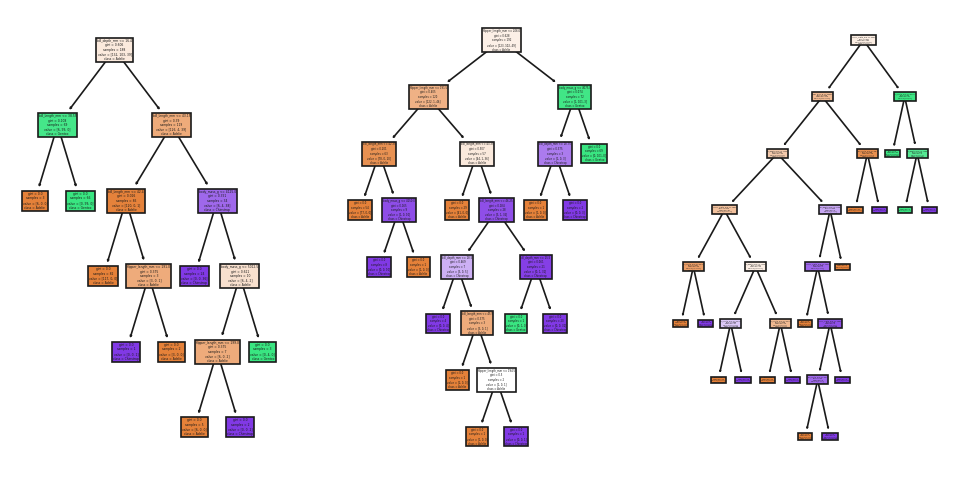

In [92]:
X = penguins_cont.drop("species",axis=1).values
y = penguins_cont[["species"]].replace({'Adelie': 0, 'Gentoo': 1, "Chinstrap":2}).values.flatten()
feat_names = penguins_cont.drop("species",axis=1).columns
class_names=['Adelie', 'Gentoo', 'Chinstrap']

RF = RandomForestClassifier(criterion='gini',
                            n_estimators=100,
                            max_samples=0.8,
                            max_features = 2,
                            random_state=42,
                            n_jobs=-1)

RF.fit(X, y)

plot_trees = 3
fig, axes = plt.subplots(ncols=plot_trees, figsize=(10,5))
with plt.style.context("classic"):
    for i in range(plot_trees):
        plt.sca(axes[i])
        plot_tree(RF.estimators_[i],
                       feature_names=feat_names, 
                       class_names=class_names,
                       filled = True)
    plt.show()

In [83]:
from math import sqrt

RF = RandomForestClassifier(criterion='gini',
                            n_estimators=100,
                            max_samples=0.8,
                            max_features = 2,
                            random_state=42,
                            n_jobs=-1)

DT = DecisionTreeClassifier(criterion='gini',
                            random_state=42)
bag = BaggingClassifier(base_estimator=DT, 
                        n_estimators=100, 
                        max_samples=0.8, 
                        max_features=2, 
                        bootstrap=True, 
                        bootstrap_features=True, 
                        oob_score=False, 
                        warm_start=False,
                        n_jobs=-1, 
                        random_state=42)

print(color.BOLD+color.UNDERLINE+"Bagged Trees"+color.END)
%timeit bag.fit(X, y)
print(color.BOLD+color.UNDERLINE+"Random Forest"+color.END)
%timeit RF.fit(X, y)

Bagged Trees
49.5 ms ± 4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Random Forest
118 ms ± 2.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Lets look at how a descion boundary created by a bagged tree could generalise better than a single tree

__TODO__
- do this on training and val data to show how the val data could cross the boundary?

In [21]:
from mlxtend.plotting import plot_decision_regions
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

def tvf_regions():

    tree = DecisionTreeClassifier(criterion='gini',
                                  random_state=42)

    forest = RandomForestClassifier(criterion='gini',
                                    n_estimators=100,
                                    max_features = 'sqrt',
                                    random_state=42,
                                    n_jobs=-1)

    tree_dict = {'Tree':tree, 'Forest':forest}

    fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
    for i, classifier_name in enumerate(tree_dict):
        plt.sca(axes[i])

        tree_dict[classifier_name].fit(Xblbd, y)

        plot_decision_regions(Xblbd, y,
                              clf = tree_dict[classifier_name])

        #plt.xlabel(x_axis_label) 
        #plt.ylabel(y_axis_label)

        plt.title(classifier_name)
    plt.show()

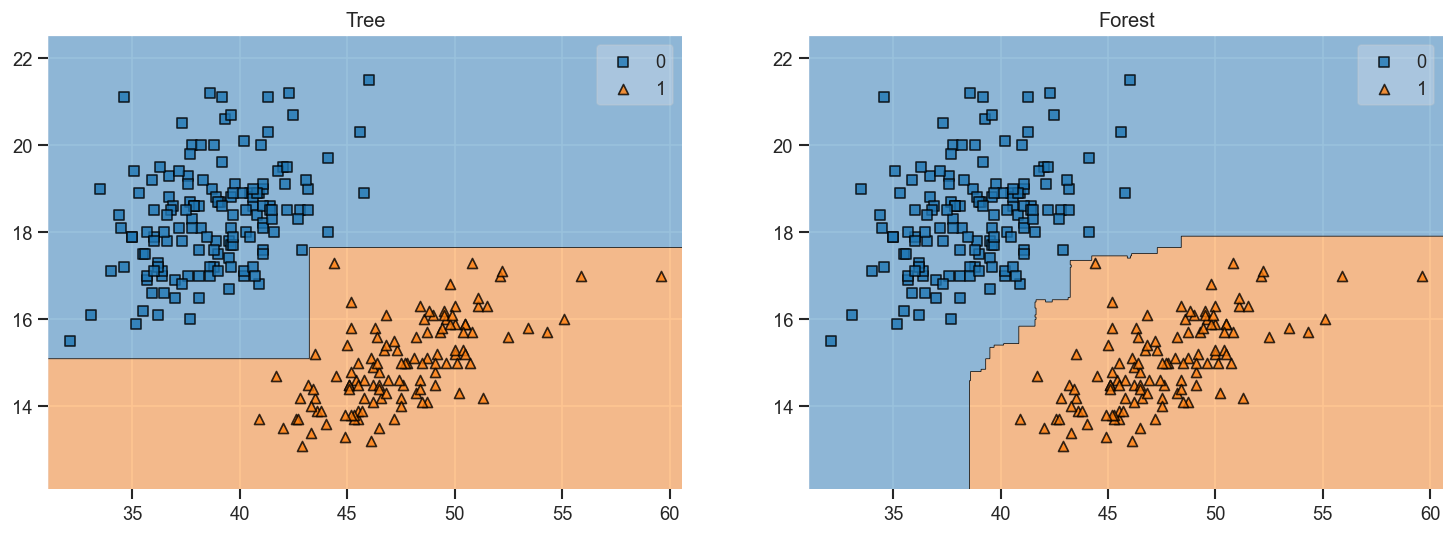

In [22]:
tvf_regions()

### Extremely Randomized Trees
As averaging methods work best when the predictors are as independent as possible<sup>2</sup>, we may specifically want our trees in our ensemble to be more independent. 

An extratree is similar to a tree classifier except it more randomized and thusly produces more complex trees. 

Instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule.

When used in an ensemble, this usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias<sup>2</sup>.

---
1. Geurts, P., Ernst, D., & Wehenkel, L. (2006). Extremely randomized trees. Machine learning, 63(1), 3-42.
2. https://scikit-learn.org/stable/modules/ensemble.html
3. Géron, A. (2017). Hands-on machine learning with Scikit-Learn and TensorFlow: concepts, tools, and techniques to build intelligent systems. " O'Reilly Media, Inc.".

In [29]:
from sklearn.tree import ExtraTreeClassifier

ET = ExtraTreeClassifier(criterion='gini',
                         random_state=42,
                         max_depth = None)

ET.fit(X, y)

ExtraTreeClassifier(random_state=42)

As we can see how just one tree looks, this is a very complex model!

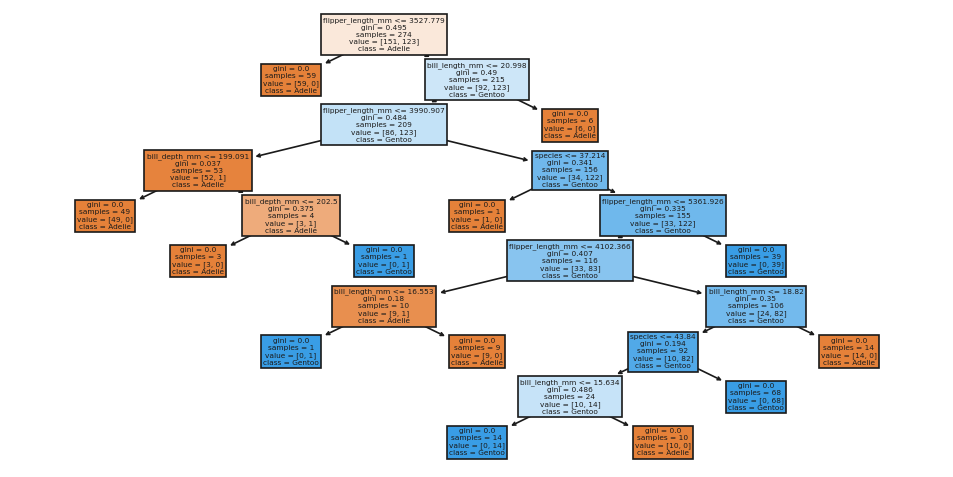

In [31]:
fig, axes = plt.subplots(figsize=(10, 5))
with plt.style.context("classic"):
    tree.plot_tree(ET,
                   feature_names=penguins_cont.columns, 
                   class_names=['Adelie', 'Gentoo'],
                   filled = True)
    plt.show()

## Exercises
[THEORY BASED!]

1.

2.

# Boosting

## Exercises
[THEORY BASED!]

1.

2.

# Implimentation

__TODO__
- add some pruning to the mix
- Dont record this bit, just leave it in the notebook

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

names = ["Sex", "Length", "Diameter", "Height", "Whole weight", 
         "Shucked weight", "Viscera weight", "Shell weight", "Rings"]

df = pd.read_csv("abalone_data.csv", names=names)
y_labels = df["Sex"]
X = df.drop("Sex", axis=1)

# create a dictionary with the our int labels
labels_multi = dict(zip(y_labels.unique(), range(3)))

# make a binary version - infants vs. adults
labels_bin = labels_multi.copy()
labels_bin['F'] = 0; labels_bin['I'] = 1

# replace the labels so they are now binary
y_bin = y_labels.replace(labels_bin)

X_train, X_test, y_train, y_test = train_test_split(X.values, y_bin.values, test_size = 0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=42)

__[TEXT]__

In [76]:
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier(criterion='gini',
                            max_depth = 6,
                            random_state=42)

DT.fit(X_train, y_train)
display(pd.DataFrame(classification_report(y_val, DT.predict(X_val), output_dict=True)))

0           1  accuracy   macro avg  weighted avg
precision    0.872570    0.684466  0.814649    0.778518      0.816336
recall       0.861407    0.705000  0.814649    0.783204      0.814649
f1-score     0.866953    0.694581  0.814649    0.780767      0.815422
support    469.000000  200.000000  0.814649  669.000000    669.000000

__[TEXT]__

__[TEXT]__

In [83]:
from sklearn.tree import ExtraTreeClassifier

ET = ExtraTreeClassifier(criterion='gini',
                         random_state=42,
                         max_depth = None)

ET.fit(X, y)

display(pd.DataFrame(classification_report(y_val, DT.predict(X_val), output_dict=True)))

ValueError: Number of labels=274 does not match number of samples=4177

### Random Forest/Extra Trees

In [24]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(criterion='gini',
                                n_estimators=100,
                                max_features = 'sqrt',
                                class_weight = 'balanced',
                                random_state=42,
                                n_jobs=-1)

ET = ExtraTreesClassifier(criterion='gini',
                     n_estimators=100,
                     max_features = 'sqrt',
                     class_weight = 'balanced',
                     random_state=42,
                     n_jobs=-1)

clf_dict = {"Random Forest": RF, "Extra Trees": ET}

for clf in clf_dict:

    clf.fit(X_train, y_train)

    display(pd.DataFrame(classification_report(y_val, clf.predict(X_val) , output_dict = True)))

0     1  accuracy  macro avg  weighted avg
precision   1.0   1.0       1.0        1.0           1.0
recall      1.0   1.0       1.0        1.0           1.0
f1-score    1.0   1.0       1.0        1.0           1.0
support    33.0  20.0       1.0       53.0          53.0

### Dimension Reduction
#### Model Stacking
A method growing in popularity is to use model stacking, where the input to one model is the output of another. This allows for nonlinearities to be captured in the first model, and the potential to use a simple linear model as the last layer. Deep learning is an example of model stacking as, often neural networks are layered on top of one another, to optimize both the features and the classifier simultaneously<sup>1</sup>.

---

1. Zheng, A., & Casari, A. (2018). Feature Engineering for Machine Learning: Principles and Techniques for Data Scientists. " O'Reilly Media, Inc.".

#### Feature Importances

An example of model stacking is to use the output of a decision tree–type model as input to a linear classifier. We can gain the importance for each feature by getting the average impurity decrease computed from all decision trees in the forest without regarding the linear separability of the classes. However, if features are highly correlated, one feature may be ranked highly while the information of the others not being fully captured<sup>1</sup>. 

---

1. Raschka, Sebastian, and Vahid Mirjalili. Python Machine Learning, 2nd Ed. Packt Publishing, 2017.

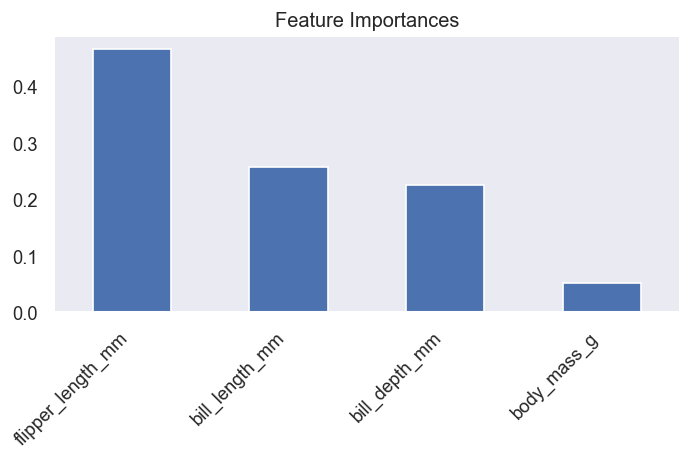

In [32]:
from sklearn.ensemble import RandomForestClassifier

# get the importances for the features
importances = forest.feature_importances_

importances_series = pd.Series(importances,index=penguins_cont.columns).sort_values(ascending = False)

# plot the important features
importances_series.plot.bar(legend =False, grid=False)
plt.title('Feature Importances')

plt.xticks(rotation=45,ha='right')
plt.tight_layout()

#plt.savefig('forest_importances.png', dpi=300)
plt.show()

#### Permutation Importance

_"impurity-based feature importances can be misleading for high cardinality features (many unique values). See `sklearn.inspection.permutation_importance` as an alternative"_ https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

Rather than manually setting a theshold like we have done (looking at the top 30) we can put it in a pipeline and use the SelectFromModel function from Scikit-learn. Using this we can still provide both a numeric theshold or we could use a heuristic such as the mean and median<sup>1</sup>.

---

1. http://scikit-learn.org/stable/modules/feature_selection.html

In [51]:
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

svm = SVC(kernel='rbf', random_state=42, class_weight = 'balanced')
rf = RandomForestClassifier(criterion='gini',
                            n_estimators=100,
                            max_features = 'sqrt',
                            random_state=42,
                            class_weight = 'balanced',
                            n_jobs=-1)

rf_svm = Pipeline([
  ('feature_selection', SelectFromModel(rf, threshold = 'mean')),
  ('classification', svm)
])

svm_dict = {'SVM':svm, 'Forest SVM':rf_svm}

for classifier_name in svm_dict:
    scores = cross_val_score(estimator=svm_dict[classifier_name], 
                             X=X_train, 
                             y=y_train, 
                             scoring = 'accuracy',
                             cv=StratifiedKFold(),
                             n_jobs=-1)

    print(color.BOLD+color.UNDERLINE+classifier_name+color.END)
    #print('CV accuracy scores: %s' % scores)
    print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

SVM
CV accuracy: 0.906 +/- 0.039
Forest SVM
CV accuracy: 0.986 +/- 0.012


#### Imballanced Data
It is also worth noting we have been dealing with the class imballance found in this data by using `class_weight = 'balanced'` to assign more importance to getting ictal data predictions correct. We can however also undersample using a ballanced random forest. Generally what performs better depends on the amount of data you are training on. If small then class wight will be better (as seen below), but if you have very large datasets, then undersampling will likely work better.

__NOTE__
- note sure this imballance is going to do much, use abalone_data?

In [52]:
from collections import Counter

print(Counter(y_train))

Counter({0: 113, 1: 99})


In [53]:
from imblearn.ensemble import BalancedRandomForestClassifier

bal_f = BalancedRandomForestClassifier(criterion='gini',
                                       n_estimators=1000,
                                       max_features = 'sqrt',
                                       random_state=42,
                                       n_jobs=-1)

rf_dict = {'Random Forest':rf, 'Balanced Random Forest':bal_f}

for classifier_name in rf_dict:
    scores = cross_val_score(estimator=rf_dict[classifier_name], 
                             X=X_train, 
                             y=y_train, 
                             scoring = 'accuracy',
                             cv=StratifiedKFold(),
                             n_jobs=-1)

    print(color.BOLD+color.UNDERLINE+classifier_name+color.END)
    #print('CV accuracy scores: %s' % scores)
    print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Random Forest
CV accuracy: 0.995 +/- 0.010
Balanced Random Forest
CV accuracy: 0.995 +/- 0.010


# References
1. James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. An introduction to statistical learning. Vol. 112. New York: springer, 2013.
2. Gorman KB, Williams TD, Fraser WR (2014). Ecological sexual dimorphism and environmental variability within a community of Antarctic penguins (genus Pygoscelis). PLoS ONE 9(3):e90081. https://doi.org/10.1371/journal.pone.0090081
3. Géron, A. (2017). Hands-on machine learning with Scikit-Learn and TensorFlow: concepts, tools, and techniques to build intelligent systems. " O'Reilly Media, Inc.".
4. Raschka, Sebastian, and Vahid Mirjalili. Python Machine Learning, 2nd Ed. Packt Publishing, 2017.